In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau
import sys
sys.path.append('..')
from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from greedy_score import Greedy
from sklearn.metrics import ndcg_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from evaluation import get_fidelity_ltr, get_auc, get_infidelity, get_fidelity_ltr, get_dpff, summarize, get_explain_ndcg
from tabulate import tabulate

In [46]:
color_list = {
    'rank_lime': 'blue',
    'lirme': 'gold',
    'lime': 'darkorange',
    'shap': 'brown',
    'exs_top_k_rank': 'cadetblue', 
    'exs_top_k_binary': 'lightgreen', 
    'exs_score': 'magenta',
    'random': 'black',
    'pmi': 'turquoise',
    'greedy_score': 'blue',
    'rank_lime': 'green',
    'gt': 'olive',
    'ff': 'khaki'
}

In [47]:
def validity_completeness(exp_val, doc_values, pred_fn, eval_key):
    instances_explained = doc_values.copy()
    base_pred_list = pred_fn(instances_explained)
    cutoff = np.linspace(0.25, 0.5, 3)
    
    total_feat = instances_explained.shape[1]
    all_pred_diff = []
    
    for cut in cutoff:
        top_k = int(np.floor(cut * total_feat))
        #print(cut, total_feat)
    
        if eval_key == 'completeness':
            feat_selected = np.abs(exp_val).argsort()[-top_k:][::-1]
        elif eval_key == 'validity': 
            feat_selected = np.abs(exp_val).argsort()[:top_k]
        else:
            raise Exception('choose either completeness or validity')
        #print('feat_selected', feat_selected)
        instances_explained[:, feat_selected] = np.mean(instances_explained[:, feat_selected], axis=0)
    
        new_pred_list = pred_fn(instances_explained)
        rank_diff = kendalltau(new_pred_list, base_pred_list).correlation
    
        base_rank_ = len(base_pred_list) - rankdata(base_pred_list).astype(int)
        new_rank_ = len(new_pred_list) - rankdata(new_pred_list).astype(int)
    
        all_pred_diff.append(np.mean(np.abs(new_rank_ - base_rank_)) / instances_explained.shape[0])
    
    return all_pred_diff

In [48]:
BASE_PATH = os.getcwd()

In [49]:
np.random.seed(10)

In [50]:
experiment_meta = [{'std': 0.1, 'dimension': 5,  'gt': [0.2, 0, 0.5, -0.3, 0]}]

In [51]:
exps = pickle.load( open( "./0/exps.p", "rb"))
q_exps = pickle.load( open( "./0/q_exps.p", "rb" ) )
df_train = pickle.load( open( "./0/synthetic_train.p", "rb" ) )
df_test = pickle.load( open( "./0/synthetic_test.p", "rb" ) )

In [52]:
indices = np.arange(0, 1010, 10)

In [53]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

In [54]:
l_exp = {}
for e in exps.keys():
    l_exp[e] = []
    for i in range(len(indices) - 1):        
        l_exp_val = np.array(exps[e][indices[i]:indices[i+1]])
        l_exp[e].append(np.mean(l_exp_val, axis=0))
for e in l_exp:
    q_exps[e] = l_exp[e]

In [55]:
selected_queries = np.unique(df_test.iloc[:, 0])[:100]
test_sample = df_test[df_test.iloc[:, 0].isin(selected_queries)]
valid_scaled = test_sample.iloc[:, :-1].values
train_scaled = df_train.iloc[:, :-1].values

In [56]:
def get_gt_similarity (exp_val, gt):
    return kendalltau(np.abs(exp_val), np.abs(gt)).statistic

In [57]:
ranker = lightgbm.Booster(model_file='./0/lmart.txt')

In [58]:
ranker.predict(valid_scaled[:10, 1:]).round(1)

array([ 2.2, -1.7, -7.1, -1. ,  0.8,  0.5,  1.4,  2.7, -1.9, -1.9])

In [59]:
doc_values = valid_scaled[indices[i]: indices[i+1], 1:]
exp_name = 'greedy_score'            
exp_val = q_exps[exp_name][i]
get_infidelity(exp_val, doc_values, ranker.predict, valid_scaled[:, 1:], top_k_percent=0.5)

0.1111111111111111

In [61]:
def evaluate(exps_file, test):
    eval = {'dpff': {}, 'fidelity_ltr': {}, 'validity': {}, 'completeness': {}, 'infidelity': {}, 'gt_similarity': {}, 'explain_ndcg': {}}
    exp_names = ['pmi', 'greedy_score', 'rank_lime', 'lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'random']
    measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity', 'gt_similarity', 'explain_ndcg']
    
    for exp_name in exp_names:
        for m in measure_keys:
            eval[m][exp_name] = []
    
    indices = np.arange(0, 1000, 10)
    
    for exp_name in exp_names:
        for i in range(len(indices) - 1):
            doc_values = test[indices[i]: indices[i+1]]
            #for exp_name in exp_names:
            exp_val = exps_file[exp_name][i].flatten()
            exp_val_normalized = min_max(exp_val)
            
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val_normalized, doc_values, ranker.predict))
            eval['validity'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'validity'))
            eval['completeness'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'completeness'))
            eval['infidelity'][exp_name].append(get_infidelity(exp_val_normalized, doc_values, ranker.predict, test, top_k_percent=0.5))
            eval['explain_ndcg'][exp_name].append(get_explain_ndcg(exp_val_normalized, doc_values, ranker.predict))
            #eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['dpff'][exp_name].append(get_dpff(exp_val, doc_values, ranker))
            eval['gt_similarity'][exp_name].append(get_gt_similarity(exp_val, experiment_meta[0]['gt']))
    return eval

In [62]:
eval = evaluate(q_exps, valid_scaled[:, 1:])

In [63]:
pickle.dump(eval, open( "./0/evaluate_summary_v3_normalized_v2.p", "wb" ) )

In [76]:
eval = pickle.load( open(  "./0/evaluate_summary_v3_normalized.p", "rb" ) )
summary_1 = summarize(eval)
summary_df_1 = pd.DataFrame(summary_1)
summary_df_1 = summary_df_1.reindex(columns=['gt_similarity','dpff', 'fidelity_ltr', 'explain_ndcg', 'completeness', 'validity', 'infidelity'])
summary_df_1 = summary_df_1.reindex(index=['pmi', 'greedy_score', 'rank_lime', 'lirme',
       'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random'])
summary_df_1.columns = ['GT Similarity','FF', 'Fidelity', 'ExplainNCDG', 'Completeness', 'Validity', 'Infidelity']
summary_df_1.index = ['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP', 'Random']

In [77]:
summary_df_1.round(2).T.style.highlight_max(axis=1)

,PMI,Greedy Score,RankLIME,LIRME,EXS (S),EXS (B),EXS (R),LIME,SHAP,Random
GT Similarity,0.910000,-0.050000,-0.310000,-0.320000,-0.310000,-0.310000,0.020000,-0.030000,-0.110000,-0.030000
FF,0.350000,0.270000,-0.100000,-0.110000,-0.100000,-0.100000,0.080000,-0.030000,-0.120000,0.050000
Fidelity,-0.340000,-0.220000,0.170000,0.160000,0.150000,0.160000,-0.150000,-0.230000,-0.200000,-0.110000
ExplainNCDG,0.700000,0.730000,0.840000,0.830000,0.830000,0.830000,0.740000,0.720000,0.740000,0.750000
Completeness,40.200000,15.300000,20.850000,21.300000,21.300000,21.300000,22.050000,21.600000,19.500000,14.100000
Validity,1.200000,15.150000,39.380000,39.380000,39.380000,39.380000,15.150000,25.280000,28.720000,25.800000
Infidelity,-0.040000,-0.040000,-0.030000,-0.030000,-0.020000,-0.050000,-0.020000,-0.000000,0.000000,-0.060000


In [42]:
print(summary_df_1.round(2).T.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &    PMI &  Greedy Score &  RankLIME &  LIRME &  EXS (S) &  EXS (B) &  EXS (R) &   LIME &   SHAP &  Random \\
\midrule
GT Similarity &   0.91 &         -0.05 &     -0.31 &  -0.32 &    -0.31 &    -0.31 &     0.02 &  -0.03 &  -0.11 &   -0.03 \\
FF            &   0.35 &          0.27 &     -0.10 &  -0.11 &    -0.10 &    -0.10 &     0.08 &  -0.03 &  -0.12 &    0.05 \\
Fidelity      &  -0.34 &         -0.22 &      0.17 &   0.16 &     0.15 &     0.16 &    -0.15 &  -0.23 &  -0.20 &   -0.11 \\
ExplainNCDG   &   0.70 &          0.73 &      0.84 &   0.83 &     0.83 &     0.83 &     0.74 &   0.72 &   0.74 &    0.75 \\
Completeness  &  40.20 &         15.30 &     20.85 &  21.30 &    21.30 &    21.30 &    22.05 &  21.60 &  19.50 &   14.10 \\
Validity      &   1.20 &         15.15 &     39.38 &  39.38 &    39.38 &    39.38 &    15.15 &  25.28 &  28.72 &   25.80 \\
Infidelity    &  -0.04 &         -0.04 &     -0.03 &  -0.03 &    -0.02 &    -0.05 &    -0.02 &  

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [21]:
exp_we_care_about = ['pmi', 'greedy_score', 'rank_lime', 'lirme','exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random']
exp_we_care_about_alt = ['pmi', 'greedy_score', 'rank_lime', 'lirme','exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random']

In [22]:
one_exp = {}
one_exp['gt'] = np.array([0.2, 0, 0.5, -0.3, 0])
one_exp['ff'] = ranker.feature_importance() / np.sum(ranker.feature_importance())
for e in exp_we_care_about:
    one_exp[e] = q_exps[e][0]

In [23]:
exp_names_figure = {
    'lime': 'LIME',
    'shap': 'SHAP',
    'lirme': 'LIRME',
    'exs_score': 'EXS (S)',
    'exs_top_k_binary': 'EXS (B)',
    'exs_top_k_rank': 'EXS (R)',
    'pmi': 'PMI',
    'greedy_score': 'Greedy Score',
    'rank_lime': 'RankLIME',
    'random': 'Random',
    'gt': 'GT (Baseline)',
    'ff': 'FF (Baseline)'
}

In [24]:
eval_one = {}
for m in eval_1.keys():
    eval_one[m] = {}
    for e in exp_we_care_about[:-2]:
        if m in ['validity', 'completeness']:
            eval_one[m][e] = np.mean(eval_1[m][e][0])
        else:
            eval_one[m][e] = eval_1[m][e][0]
eval_one = pd.DataFrame(eval_one).round(2)

In [25]:
eval_one = eval_one.reindex(columns=['gt_similarity','dpff', 'fidelity_ltr', 'explain_ndcg', 'completeness', 'validity', 'infidelity'])
eval_one.columns = ['GT Similarity','FF', 'Fidelity',  'Explain NCDG', 'Completeness', 'Validity', 'Infidelity']

eval_one.T.style.highlight_max(axis=1)

,pmi,greedy_score,rank_lime,lirme,exs_score,exs_top_k_binary,exs_top_k_rank,lime
GT Similarity,0.950000,0.110000,0.950000,0.950000,0.950000,0.950000,-0.530000,0.950000
FF,0.320000,-0.110000,0.320000,0.320000,0.320000,0.320000,0.110000,0.320000
Fidelity,-0.110000,-0.020000,1.000000,0.870000,0.870000,0.820000,-0.420000,0.730000
Explain NCDG,0.860000,0.920000,1.000000,1.000000,1.000000,0.990000,0.800000,0.990000
Completeness,0.240000,0.200000,0.240000,0.240000,0.240000,0.240000,0.120000,0.240000
Validity,0.010000,0.120000,0.030000,0.030000,0.030000,0.030000,0.240000,0.010000
Infidelity,0.380000,-0.110000,-0.420000,-0.470000,-0.420000,-0.420000,-0.380000,-0.020000


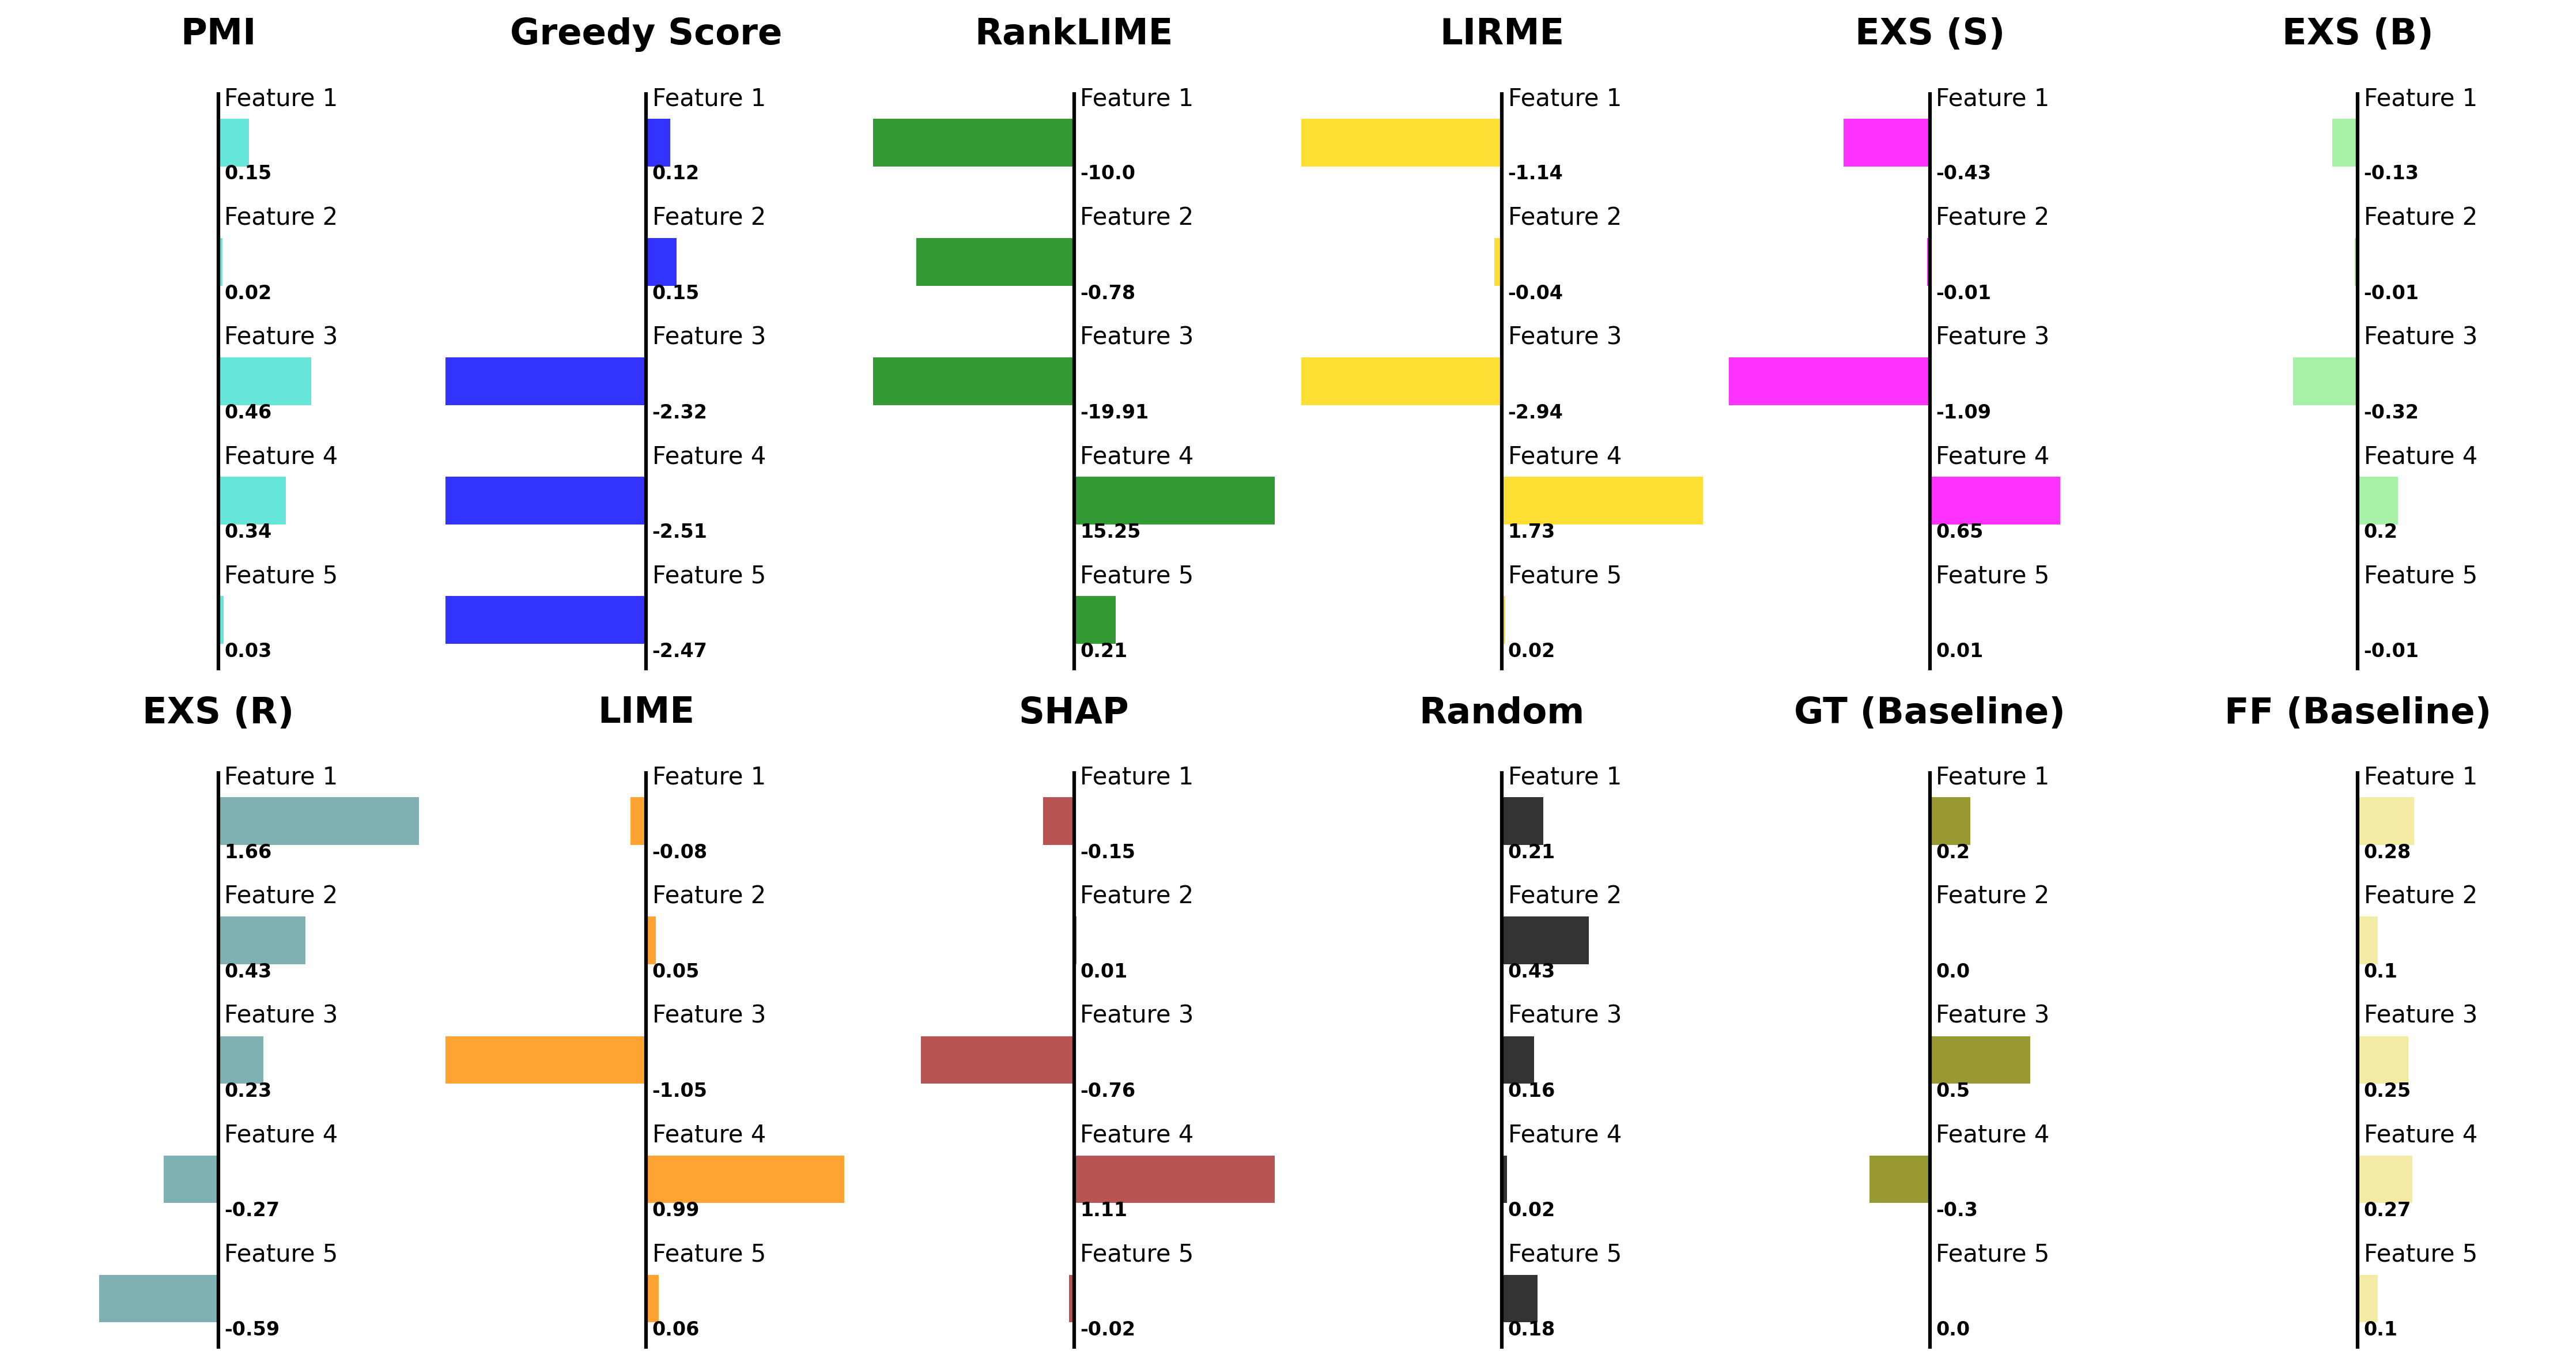

In [26]:
fig, ax = plt.subplots(2, 6, figsize=(15, 8), sharey=True, dpi=300)

ax = ax.ravel()
y_pos = np.arange(valid_scaled.shape[1])
#titles = ['Greedy-Score', 'PMI', 'Grad', 'RPI']
#feat_names = ['tf_body', 'tf_anchor', 'tf_title', 'tf_url', 'tf_all_document']
ax[0].invert_yaxis() 
feat_names = []

for i in range(1, 6):
    feat_names.append('Feature {}'.format(i))

exp_we_care_about.extend(['gt', 'ff'])

for i in range(12):  
    exp_name = exp_we_care_about[i]
    #exp_name = exp_names_alt[i]
    exp_val = one_exp[exp_name].flatten()
    ax[i].set_title(exp_names_figure[exp_we_care_about[i]], fontsize=15, fontweight='bold', pad=20)
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    #ax[i].set_ylabel('', labelpad=25)
    ax[i].tick_params(left = False, bottom = False)
    #ax[i].set_yticks(np.arange(len(features)))
    #ax[i].set_yticklabels(features, fontsize=17)
    ax[i].set_yticklabels([])
    ax[i].set_xlim([-1, 1])
    print()
    ax[i].barh(y_pos[:5], exp_val, align='center', alpha=0.8, height=0.4, color=color_list[exp_we_care_about[i]])
    #ax[i].set_yticks(y_pos)
    #ax[i].set_yticklabels(features, fontsize= 18)
    ax[i].axvline(x=0, c='black')

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    padding = 0.31
    #for j in range(len(sel_feats)):
    #for j in range(len(one_exp[subset_exps[i]])):
    for j in range(5):
        
        if exp_val[j] < 0:
            x_pos_ = 0.1
        else: 
            x_pos_ =  0.1
        ax[i].text(0.03, j + padding, np.round(exp_val[j], 2), color='black', fontweight='bold', fontsize=8)
        ax[i].text(0.03, j - padding, feat_names[j], color='black',  fontsize=10)

plt.tight_layout()
#ax[-1].axis('off')
plt.savefig('../img/example_synthetic.pdf')

In [27]:
subset_exps = ['pmi', 'greedy_score', 'rank_lime', 'lirme',
           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap']
subset_exps_alt = np.array(['PMI', 'GreedyScore', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)','LIME', 'SHAP'])
top_ks = 0.5
top_k = int(top_ks * valid_scaled.shape[1])
similarity = np.zeros((len(subset_exps), len(subset_exps)))

for i in range(0, len(subset_exps)):
    e_i = subset_exps[i]
    for j in range(i + 1):
        e_j = subset_exps[j]
        temp = []

        for k in range(len(selected_queries)):
            first_exp = q_exps[e_i][k].flatten()
            second_exp = q_exps[e_j][k].flatten()

            ranked_first = np.argsort(np.abs(first_exp))[-top_k:][::-1]
            ranked_second = np.argsort(np.abs(second_exp))[-top_k:][::-1]

            f_exp_1 = np.zeros(valid_scaled.shape[1] - 1)
            f_exp_1[ranked_first] = 1

            f_exp_2 = np.zeros(valid_scaled.shape[1] - 1)
            f_exp_2[ranked_second] = 1

            #temp.append(jaccard_score(np.abs(f_exp_1), np.abs(f_exp_2), average='binary'))
            temp.append(kendalltau(np.abs(first_exp), np.abs(second_exp)).statistic)
        similarity[i][j] = np.nanmean(temp)

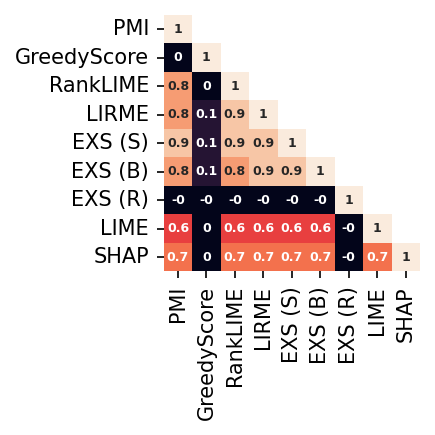

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
similarity[np.triu_indices(similarity.shape[0], +1)] = np.nan
sns.heatmap(similarity.round(1), xticklabels=subset_exps_alt, yticklabels=subset_exps_alt, 
        annot=True, annot_kws={"fontsize":6, 'fontweight':'bold'}, ax=ax, cbar=False)
plt.tight_layout()
plt.savefig('../img/pairwise_synthetic.pdf')
plt.show()

subset_test = df_test.iloc[:400]
from listwise_exp import pmi_exp, rpi_exp, grad_q_exp, greedy_exp, random_q_exp
from ranklime import RankLIME
rlime = RankLIME(valid_scaled[:1000, 1:])

q_exps = {'pmi': [], 'rpi': [], 'grad': [], 'rank_lime': [], 'greedy_score': [], 'random': []}


#q_exps = {'pmi': [],  'rank_lime': [], 'greedy_score': [], 'random': []}

for i, row in subset_test.groupby(0):
    if i % 10 == 0:
        print(i)
    doc_values = row.loc[:, 1:5].values
    
    q_exps['pmi'].append(pmi_exp(doc_values, ranker))
    q_exps['rpi'].append(rpi_exp(doc_values, ranker))
    q_exps['grad'].append(grad_q_exp(doc_values, ranker))
    q_exps['rank_lime'].append(rlime.explain(doc_values, ranker.predict, []))
    q_exps['greedy_score'].append(greedy_exp(doc_values, ranker.predict))
    q_exps['random'].append(random_q_exp(doc_values))

pickle.dump(q_exps, open( "./synthetic_query_exps_v1.p", "wb" ) )

In [139]:
doc_values = valid_scaled[:, 1:][:10]
output = ranker.predict(doc_values)

In [140]:
prod = np.dot(doc_values, e)
kendalltau(prod, output).statistic

0.9999999999999999

In [141]:
prod_trans = np.dot(doc_values, e_trans)
kendalltau(prod_trans, output).statistic

-0.022222222222222223